We will be using `fastai2` which is still under active development. I am using pip editable install as explained in the [fastai2 repository](https://github.com/fastai/fastai2). This gives me a little bit more of control and also allows me to to navigate through the code. 

Alternatively, you can install `fastai2` directly from github: `pip install git+https://github.com/fastai/fastai2`

When working on this notebook, I was at the following version (hash in git commits) of the library: `3f27f55bb298591aef8f2f72e32615317cc2f77e`

In [1]:
from fastai2.test import *
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.vision.all import *

from pathlib import Path
import pandas as pd
import numpy as np
import librosa

The first order of business will be to read in our data.

In [2]:
trn_df = pd.read_csv('data/train.csv')
trn_paths = list(Path('data/audio_train/').iterdir())

In [3]:
trn_paths[:4]

[PosixPath('data/audio_train/5fca79da.wav'),
 PosixPath('data/audio_train/5f3f655e.wav'),
 PosixPath('data/audio_train/8c0e42bb.wav'),
 PosixPath('data/audio_train/a9bd898d.wav')]

Our first model will be a simple CNN on first two seconds of audio downsampled to 16 khz.

Let's load the data with the medium-level `DataSource` API. Let's first define how the sounds should be read in and later we will look at constructing the labels.

We could resample the audio files on the fly, but that is quite an expensive operation. It's better to incur this cost ones before training and save the results vs having to suffer it during every epoch.

In [4]:
path = trn_paths[0]

In [5]:
%time librosa.core.load(path, sr=16000)

CPU times: user 787 ms, sys: 22.5 ms, total: 809 ms
Wall time: 855 ms


(array([-4.5412817e-06, -4.5701829e-05, -1.4590675e-05, ...,
        -1.3681429e-05, -4.5426914e-05, -5.1247978e-05], dtype=float32), 16000)

In [6]:
%time librosa.core.load(path, sr=None)

CPU times: user 1.99 ms, sys: 1e+03 ns, total: 1.99 ms
Wall time: 1.47 ms


(array([ 0.0000000e+00, -3.0517578e-05, -3.0517578e-05, ...,
        -3.0517578e-05, -6.1035156e-05, -3.0517578e-05], dtype=float32), 44100)

Reading a file without resampling is much, much quicker.

Let's resample the files beforehand and save them to disk.

In [7]:
!rm -rf data/audio_train_22k
!rm -rf data/audio_test_22k

In [8]:
!mkdir data/audio_train_22k
!mkdir data/audio_test_22k

In the multiple runs I carried out, setting `norm=True` performed better. But I am not really sure how this normalization work. I am also not sure if the difference in performance is due to the specific architecture we go for being particularly susceptible, or whether this normalization in general is a net positive.

Without more information I am concerned setting `norm=False` would remove useful information from the data.

Initially, I resampled the data to 16 khz. But upon reading more on the forums, that might not have been such a great idea. The dataset contains sounds that are not only human speech, becaue of [the nyquist frequency] that means that with 16 khz there is significant chance that we would loose useful information. Going with 22050 instead.

In [9]:
def resample(path, target_sr, output_dir):
    x, sr = librosa.core.load(path, sr=target_sr)
    librosa.output.write_wav(f'{output_dir}/{path.name}', x, sr, norm=False)
    
def resample_train(path): resample(path, 22050, 'data/audio_train_22k/')
def resample_test(path): resample(path, 22050, 'data/audio_test_22k/')

In [10]:
%time parallel(resample_train, trn_paths)

CPU times: user 4.57 s, sys: 655 ms, total: 5.22 s
Wall time: 3min 30s


(#9473) [None,None,None,None,None,None,None,None,None,None...]

There are 3 files in the test set that are corrupt - let's remove them before proceeding.

In [11]:
tst_paths = list(Path('data/audio_test/').iterdir())

In [12]:
%time parallel(resample_test, tst_paths)

CPU times: user 4.34 s, sys: 650 ms, total: 4.99 s
Wall time: 2min 51s


(#9400) [None,None,None,None,None,None,None,None,None,None...]

### Loading the data with DataSource

In [5]:
trn_paths = list(Path('data/audio_train_22k/').iterdir())
tst_paths = list(Path('data/audio_test_22k/').iterdir())

In [6]:
def open_audio_file(path):
    x, sr = librosa.core.load(path, sr=None)
    return np.pad(x, (0, 72_000), 'constant')[:32_000].reshape(1, -1)

In [7]:
trn_df_idx = trn_df.set_index('fname')

In [8]:
def item_to_label(path): return trn_df_idx.loc[path.name].label

In [9]:
tfms = [[open_audio_file], [item_to_label, Categorize()]]
item_audio_tfms = [ToTensor()]

Randomly assigning 20% of data to the validation set.

In [10]:
split_idxs = RandomSplitter()(trn_paths)

In [11]:
dsrc = DataSource(trn_paths, tfms, splits=split_idxs)

In [12]:
batch_tfms = [Cuda()]
dbch = dsrc.databunch(after_item=item_audio_tfms, after_batch=batch_tfms, bs=128, num_workers=12)

Let's calculate the mean and standard deviation on the train set for normalization.

In [13]:
means, std_devs = [], []

for batch in dbch.train_dl:
    means.append(batch[0].mean().cpu().item())
    std_devs.append(batch[0].std().cpu().item())

This skips the 20% of data that got assigned to the validation set, but should be good enough.

In [14]:
np.mean(means), np.mean(std_devs)

(8.125128800787995e-05, 0.11881321794905905)

The mean is very close to zero, so that is something that we can disregard, but let's make sure divide the signal by 0.114 before we feed it to the model.

In [15]:
def open_audio_file(path):
    x, sr = librosa.core.load(path, sr=None)
    return np.pad(x, (0, 72_000), 'constant')[:32_000].reshape(1, -1) / 0.11 # normalizing the data

tfms = [[open_audio_file], [item_to_label, Categorize()]]
item_audio_tfms = [ToTensor()]

dsrc = DataSource(trn_paths, tfms, splits=split_idxs)
batch_tfms = [Cuda()]
dbch = dsrc.databunch(after_item=item_audio_tfms, after_batch=batch_tfms, bs=128, num_workers=12)

In [16]:
means, std_devs = [], []

for batch in dbch.train_dl:
    means.append(batch[0].mean().cpu().item())
    std_devs.append(batch[0].std().cpu().item())

In [17]:
np.mean(means), np.mean(std_devs)

(0.0009544457394533033, 1.0828915400020147)

And we are all set. Mean of 0 and a standard deviation of 1 will make the task slightly easier for our model.

### Building the model

Let's initially use the Conv1d architecture from this [tutorial](https://www.kaggle.com/fizzbuzz/beginner-s-guide-to-audio-data)

In [18]:
def conv_block(in_channels, out_channels, kernel_size):
    return nn.Sequential(
        nn.Conv1d(in_channels, out_channels, kernel_size),
        nn.ReLU(),
        nn.BatchNorm1d(out_channels),
        nn.Conv1d(out_channels, out_channels, kernel_size),
        nn.ReLU(),
        nn.BatchNorm1d(out_channels),
    )

In [19]:
def pool_and_dropout_block(pool_size):
    return nn.Sequential(
        nn.MaxPool1d(pool_size),
        nn.Dropout(0.1)
    )

In [20]:
def fc_block(in_features, out_features):
    return nn.Sequential(
        nn.Linear(in_features, out_features),
        nn.ReLU(),
        nn.BatchNorm1d(out_features),
    )

In [21]:
arch = nn.Sequential(
    conv_block(1, 16, 9),
    pool_and_dropout_block(16),
    conv_block(16, 32, 3),
    pool_and_dropout_block(4),
    conv_block(32, 64, 3),
    pool_and_dropout_block(4),
    conv_block(64, 128, 3),
    nn.AdaptiveAvgPool1d(1),
    Flatten(),
    fc_block(128, 128),
    fc_block(128, 128),
    nn.Linear(128, dbch.c)
)

In [22]:
learn = Learner(dbch, arch, metrics=[accuracy, lambda preds, targs: top_k_accuracy(preds, targs, 3)],
                opt_func=partial(Adam, wd=0.01, eps=1e-3)
                )

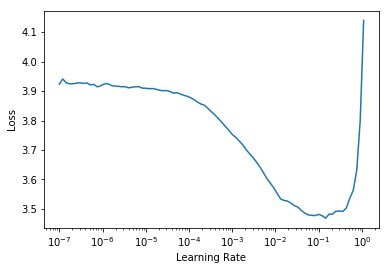

In [23]:
learn.lr_find()

In [24]:
learn.fit_one_cycle(10, 5e-3)

epoch,train_loss,valid_loss,accuracy,,time
0,3.132170,3.500645,0.128828,0.296726,00:09
1,2.700035,3.244796,0.190074,0.398099,00:08
2,2.440974,3.417784,0.256600,0.486272,00:08
3,2.234478,4.147653,0.242872,0.437170,00:08
4,2.088425,2.628986,0.313622,0.541711,00:08
5,1.913654,2.481786,0.328933,0.573390,00:08
6,1.737189,2.029810,0.437170,0.668427,00:08
7,1.573490,1.829506,0.484161,0.719113,00:08
8,1.445058,1.766687,0.519007,0.725449,00:08
9,1.356677,1.740500,0.521647,0.729145,00:08


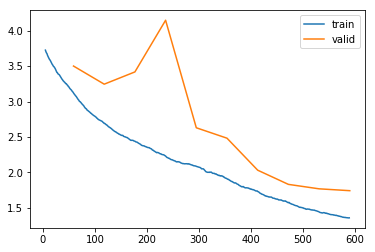

In [25]:
learn.recorder.plot_loss()

In [26]:
learn.save('basic_1')

Let's grab the predictions on the test set

In [27]:
test_dl = test_dl(dbch, tst_paths)
preds_1 = learn.get_preds(dl=test_dl)[0]

Top 3 accuracy of 0.76 is not looking bad at all. Let's quickly hack together a model using dilated convolutions, without max pooling, and see how we fare.

In [28]:
def conv_block(in_channels, out_channels, kernel_size, stride=1, dilation=1, extra_blocks=1):
    extra_blocks = []
    for _ in extra_blocks:
        extra_blocks += [
            nn.Conv1d(out_channels, out_channels, kernel_size, stride=stride, dilation=dilation),
            nn.ReLU(),
            nn.BatchNorm1d(out_channels)
        ]
    return nn.Sequential(
        nn.Conv1d(in_channels, out_channels, kernel_size, stride=stride, dilation=dilation),
        nn.ReLU(),
        nn.BatchNorm1d(out_channels),
        *extra_blocks
    )

In [29]:
arch = nn.Sequential(
    conv_block(1, 8, 16),
    conv_block(8, 16, 16, dilation=16),
    conv_block(16, 32, 9, stride=16),
    conv_block(32, 64, 16),
    conv_block(64, 128, 16, dilation=16),
    conv_block(128, 128, 9, stride=16),
    nn.AdaptiveAvgPool1d(1),
    Flatten(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.BatchNorm1d(128),
    nn.Linear(128, dbch.c)
)

In [30]:
learn = Learner(dbch, arch, metrics=[accuracy, lambda preds, targs: top_k_accuracy(preds, targs, 3)],
                opt_func=partial(Adam, wd=0.01, eps=1e-3)
                )

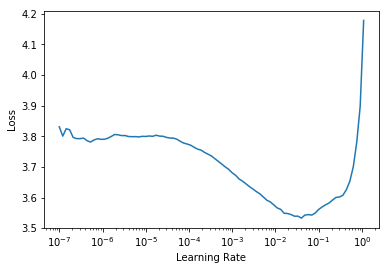

In [31]:
learn.lr_find()

In [32]:
learn.fit_one_cycle(10, 3e-3)

epoch,train_loss,valid_loss,accuracy,,time
0,3.326890,3.341169,0.140971,0.266631,00:13
1,2.959444,3.185332,0.212249,0.398627,00:11
2,2.654326,2.602371,0.301478,0.537487,00:11
3,2.389705,4.297579,0.227033,0.395987,00:11
4,2.181204,2.241556,0.389652,0.604541,00:11
5,2.021274,2.137793,0.407603,0.627772,00:11
6,1.845770,2.505543,0.337381,0.557550,00:11
7,1.674489,1.803225,0.505280,0.705913,00:11
8,1.545435,1.747851,0.523759,0.718585,00:12
9,1.456423,1.714429,0.536431,0.731785,00:11


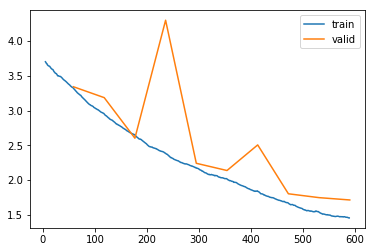

In [33]:
learn.recorder.plot_loss()

In [34]:
learn.save('basic_2')

In [35]:
preds_2 = learn.get_preds(dl=test_dl)[0]

In [36]:
preds = 0.5 * preds_1 + 0.5 * preds_2

In [37]:
predicted_label_idxs = preds.argsort(descending=True)[:, :3]

In [38]:
fns, predicted_labels = [], []

for path, idxs in zip(tst_paths, predicted_label_idxs):
    fns.append(path.name)
    predicted_labels.append([dbch.vocab[idx] for idx in idxs])

Adding entries for the corrupted files

In [39]:
len(fns)

9400

In [40]:
sub = pd.DataFrame({'fname': fns, 'label': predicted_labels})
sub.label = sub.label.apply(lambda lst: ' '.join(lst))

In [41]:
sub.head()

,fname,label
0,d2217d56.wav,Bass_drum Knock Finger_snapping
1,614a7c76.wav,Flute Clarinet Cello
2,02198549.wav,Scissors Keys_jangling Computer_keyboard
3,e6eb9ec4.wav,Saxophone Flute Clarinet
4,0da592f2.wav,Clarinet Flute Saxophone


In [42]:
mkdir -p data/submissions

In [43]:
sub_name = 'basic_models_averaged_predictions'
sub.to_csv(f'data/submissions/{sub_name}.csv.zip', compression='zip', index=False)

In [44]:
!kaggle competitions submit -c freesound-audio-tagging -f data/submissions/{sub_name}.csv.zip -m {sub_name}

100%|██████████████████████████████████████| 89.2k/89.2k [00:03<00:00, 24.8kB/s]
Successfully submitted to Freesound General-Purpose Audio Tagging Challenge